In [5]:

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from __future__ import print_function
from pprint import pprint
from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from astropy.table import Table
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
tpf = KeplerTargetPixelFile.from_archive(220381074)   #KeplerTargetPixelFile
lc = tpf.to_lightcurve(aperture_mask='all')           #KeplerLightCurve

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()  
print(lc.flux)

[7916.004  7931.981  7910.661  ... 7843.703  7822.35   7789.4023]


In [7]:
import lightkurve.injection as inj
import lightkurve.lightcurve as lightcurve

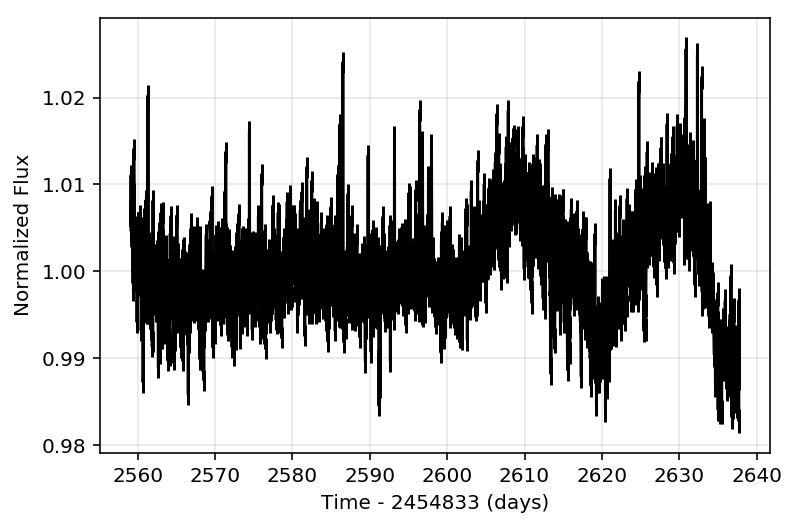

In [17]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=3.e-4)
lcinj = inj.inject(lc, model)
lc.plot()

GULLY: The injected light curve looks like this after the units fix:

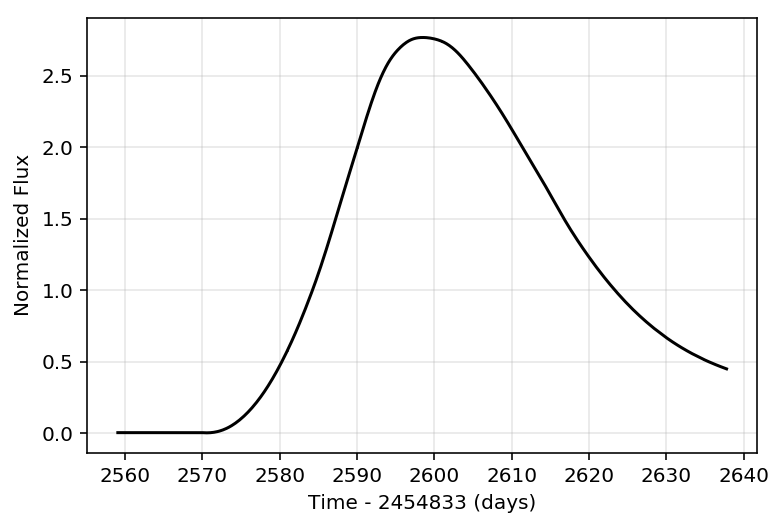

In [18]:
lcinj.plot()

I'm not sure what's happening but the injected lc doesn't look like it's being injected correctly. If I revert back to the version without the units fix it looks like an injected supernova.

In [35]:
lcinj = lcinj.remove_nans()
lcinj = lcinj.normalize()

In [46]:
fit = inj.recover(lcinj, 'Supernova')
print(fit)

 final_simplex: (array([[ 1.73502514e+04,  2.53129045e-01, -1.33684955e-01,
         1.19958586e+00],
       [ 1.73502515e+04,  2.53129045e-01, -1.33684955e-01,
         1.19958586e+00],
       [ 1.73502514e+04,  2.53129045e-01, -1.33684955e-01,
         1.19958586e+00],
       [ 1.73502514e+04,  2.53129045e-01, -1.33684955e-01,
         1.19958586e+00],
       [ 1.73502514e+04,  2.53129045e-01, -1.33684955e-01,
         1.19958586e+00]]), array([5.44871617e+13, 5.44871617e+13, 5.44871617e+13, 5.44871617e+13,
       5.44871617e+13]))
           fun: 54487161736920.61
       message: 'Optimization terminated successfully.'
          nfev: 329
           nit: 163
        status: 0
       success: True
             x: array([ 1.73502514e+04,  2.53129045e-01, -1.33684955e-01,  1.19958586e+00])
[ 1.73502514e+04  2.53129045e-01 -1.33684955e-01  1.19958586e+00]


In [36]:
model_fit = inj.SupernovaModel(T0=fit[0], source='hsiao', bandpass='kepler', z=fit[1], amplitude=fit[2])
model_eval = model_fit.evaluate(lc.time)

print(model_eval)
print(lc.flux)

print(np.nanmedian(lc.flux))

model_eval = model_eval + np.nanmedian(lc.flux)
model_eval = model_eval / np.nanmedian(model_eval)
model_synth_fit = lightcurve.SyntheticLightCurve(lc.time, flux=model_eval)


[1.24860720e-14 1.24860720e-14 1.24860720e-14 ... 1.43806768e+05
 1.43623094e+05 1.43439678e+05]
[7916.004  7931.981  7910.661  ... 7843.703  7822.35   7789.4023]
7870.0615


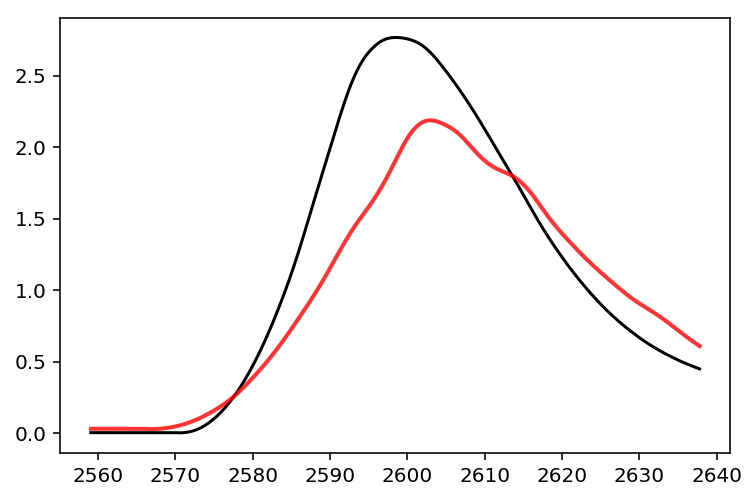

In [32]:
#lcinj.plot()
plt.plot(lc.time, lcinj.flux, color='k')
plt.plot(lc.time, model_synth_fit.flux, color='red', lw=2, ls='-',
        alpha=0.8)
#model_synth_fit.plot()

In [ ]:
tpf = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
lc = tpf.to_lightcurve(aperture_mask='all')

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers()

In [ ]:
model = inj.TransitModel()
model.add_star(zpt=1.0, rho=1.5, ld1=0.2, ld2=0.4, dil=0.01)
model.add_planet(period=5, T0=134, rprs=.1, impact=0.0)


lc_transit = inj.inject(lc, model)
lc_transit = lc_transit.normalize()

In [ ]:
lc_transit.plot()
plt.title('KIC 1867630 with injections')
plt.ylim(0.985, 1.004)

In [ ]:
fit = inj.recover(lc_transit, 'Planet')
print(fit)
#T0, period, rprs, impact = theta

In [301]:
model_fit = inj.TransitModel()
model_fit.add_star(zpt=1.0, rho=1.5, ld1=0.2, ld2=0.4, dil=0.01)
model_fit.add_planet(period=fit[1], T0=fit[0], rprs=fit[2], impact=fit[3])
model_fit = model_fit.evaluate(lc.time)

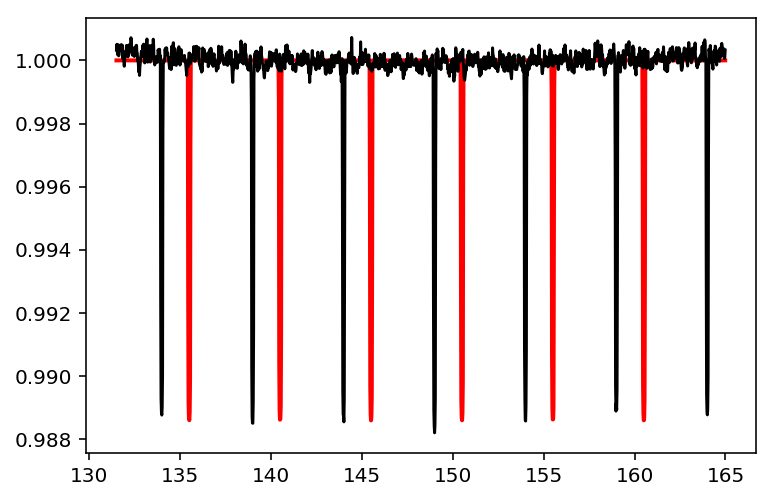

In [302]:
plt.plot(lc.time, model_fit, color = 'r', lw=2)
plt.plot(lc.time, lc_transit.flux, color='k')